In [82]:
#Process docking results and correlate RMSD with chemical features of molecules
#11/13/23 added an update- Spearman correlation
#Hoping to obtain a file of protein features/P-L complex features, which can also be correlated with RMSD
#11/28/23 add on binding site info and nearby water info
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Chem import Descriptors
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats

In [83]:
results_d = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/TEST3_top40_epoch75_FILTER_restart_cacheNewRestart_big_ema_ESM2emb_tr34_WITH_fixedSamples28_id1_FILTERFROM_temp_restart_ema_ESM2emb_tr34"

In [94]:
#From Hannes
with open(f'{results_d}/complex_names.npy', 'rb') as f:
    complex_names = np.load(f)
with open(f'{results_d}/rmsds.npy', 'rb') as f:
    rmsds = np.load(f)
with open(f'{results_d}/confidences.npy', 'rb') as f:
    confidences = np.load(f)
    
#Dina adds 11/28/23 info on protein binding site chemistry
with open('/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Site_Comp_231128/Binding_site_composition_Cutoff_3.7.npy', 'rb') as f:
    bsite_comp = np.load(f, allow_pickle = True)
    
with open('/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Site_Comp_231128/Nearby_W_Cutoff_3.7.npy', 'rb') as f:
    w_info = np.load(f, allow_pickle = True)

In [95]:
len(rmsds[0])

40

In [96]:
len(confidences[0])

40

In [97]:
len(complex_names)

363

In [98]:
complex_names

array(['6qqw', '6d08', '6jap', '6np2', '6uvp', '6oxq', '6jsn', '6hzb',
       '6qrc', '6oio', '6jag', '6moa', '6hld', '6i9a', '6e4c', '6g24',
       '6jb4', '6s55', '6seo', '6dyz', '5zk5', '6jid', '5ze6', '6qlu',
       '6a6k', '6qgf', '6e3z', '6te6', '6pka', '6g2o', '6jsf', '5zxk',
       '6qxd', '6n97', '6jt3', '6qtr', '6oy1', '6n96', '6qzh', '6qqz',
       '6qmt', '6ibx', '6hmt', '5zk7', '6k3l', '6cjs', '6n9l', '6ibz',
       '6ott', '6gge', '6hot', '6e3p', '6md6', '6hlb', '6fe5', '6uwp',
       '6npp', '6g2f', '6mo7', '6bqd', '6nsv', '6i76', '6n53', '6g2c',
       '6eeb', '6n0m', '6uvy', '6ovz', '6olx', '6v5l', '6hhg', '5zcu',
       '6dz2', '6mjq', '6efk', '6s9w', '6gdy', '6kqi', '6ueg', '6oxt',
       '6oy0', '6qr7', '6i41', '6cyg', '6qmr', '6g27', '6ggb', '6g3c',
       '6n4e', '6fcj', '6quv', '6iql', '6i74', '6qr4', '6rnu', '6jib',
       '6izq', '6qw8', '6qto', '6qrd', '6hza', '6e5s', '6dz3', '6e6w',
       '6cyh', '5zlf', '6om4', '6gga', '6pgp', '6qqv', '6qtq', '6gj6',
      

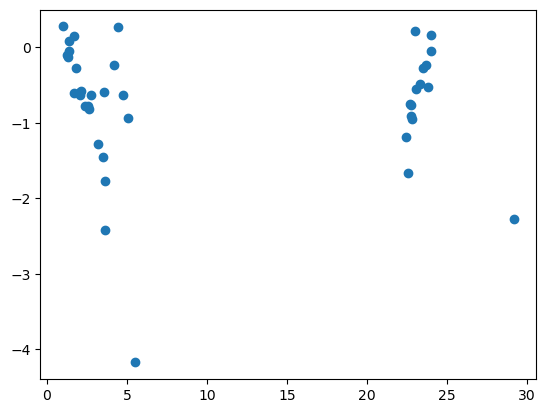

In [99]:
plt.scatter(rmsds[0], confidences[0])

In [100]:
#Copied from https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py
def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=False):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)
    except Exception as e:
        print(e)
        print("RDKit was unable to read the molecule.")
        return None

    return mol

In [101]:
#Make dataframe of pdb ids and rmsds
#Inputs:
#(a) name_info names of pdbs
#(b) rmsd_info rmsds
#(c) confidence_info confidences for each rmsd
#(d) pdbpath path to PDBBind structures
#(e) bsite_cd binding site info dictionary
#(f) w_info_d water info dictionary
#Output:
#pd_df ddataframe with RMSD results and info on each complex
def create_df(name_info, rmsd_info, confidence_info, pdbpath, bsite_cd, w_info_d):
    name_list = name_info
    top_rmsd_list = []
    top_confidence_list = []
    
    #ID top confidence rmsd
    #Hannes code helped a lot
    for rmsd_for_pdb, conf_for_pdb in zip(rmsd_info, confidence_info):
        #print("NEW")
        #print(f"max confidence {max(conf_for_pdb)}")
        
        #Get ranked confidences and associate rmsds for each confidence
        #Ref https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
        conf_ordered = np.argsort(conf_for_pdb)
        #print("ordered and conf")
        #print(conf_ordered)
        #print(conf_for_pdb)
        #print("confidences in order")
        #print(conf_for_pdb[conf_ordered])
        #print("rmsd by confidence")
        #print(rmsd_for_pdb[conf_ordered])
        #for ci, cv in zip(sorted(conf_ordered), conf_for_pdb):
        #    print(f"{ci} rank val is {cv[ci]}")
        #    print(cv[])
        
        top_rmsd_list.append(rmsd_for_pdb[conf_ordered][-1])
        top_confidence_list.append(conf_for_pdb[conf_ordered][-1])
        
        #Pull ligand info
        #ligand_path = ""
        
    
    #Lists of props ffor df
    ligand_smiles = []
    logp = []
    heteroatompct = []
    heteroatomcount = []
    tpsa = []
    numaliphaticrings = []
    numaliphaticringsnorm = []
    allatomcount = []
    rg = []
    asph = []
    kd_value = []
    bsite_res = []
    waters = []
    
    #Pull sdf/mol2 and then smiles
    for pdb_name in name_info:

        #Copied below from https://github.com/gcorso/DiffDock/blob/main/datasets/pdbbind.py
        for file in os.listdir(os.path.join(pdbpath, pdb_name)):
            if file.endswith(".sdf") and 'rdkit' not in file:
                lig = read_molecule(os.path.join(pdbpath, pdb_name, file), remove_hs=False, sanitize=True)
                if lig is None and os.path.exists(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2")):  # read mol2 file if sdf file cannot be sanitized
                    print('Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.')
                    lig = read_molecule(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2"), remove_hs=False, sanitize=True)
                
                #Process molecule
                #Ref https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors
                #Ref https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html#module-rdkit.Chem.Descriptors
                #Ref https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors
                #Ref https://www.rdkit.org/docs/GettingStartedInPython.html
                #Ref https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors3D.html
                if lig is not None: 
                    ligand_smiles.append(Chem.MolToSmiles(lig))
                    logp.append(Descriptors.MolLogP(lig))
                    heteroatompct.append(float(Descriptors.NumHeteroatoms(lig)) / float(Descriptors.HeavyAtomCount(lig)))
                    heteroatomcount.append(float(Descriptors.NumHeteroatoms(lig)))
                    numaliphaticrings.append(Descriptors.NumAliphaticRings(lig))  
                    numaliphaticringsnorm.append(float(Descriptors.NumAliphaticRings(lig)) / float(Descriptors.HeavyAtomCount(lig)))
                    allatomcount.append(Descriptors.HeavyAtomCount(lig))
                    tpsa.append(Descriptors.TPSA(lig))
                    rg.append(rdkit.Chem.Descriptors3D.RadiusOfGyration(lig))
                    asph.append(rdkit.Chem.Descriptors3D.Asphericity(lig))
                else:
                    ligand_smiles.append("NOSMILESSTRING")
                    logp.append("NOLOGP")
                    heteroatompct.append("NODATA")
                    
        #11/28/23 add on binding site information
        kd_value.append(bsite_cd[pdb_name]["average_kd"])
        bsite_res.append(bsite_cd[pdb_name]["residues"])
        waters.append(w_info_d[pdb_name])
    
    #Create dict, df
    dict_of_molec_info = {"names" : name_info,
                          "top_rmsd" : top_rmsd_list,
                          "top_confidence" : top_confidence_list,
                          "ligand_smiles" : ligand_smiles, 
                          "LogP" : logp,
                          "PctHeteroatoms" : heteroatompct,
                          "CountHeteroatoms" : heteroatomcount,
                          "CountAllAtoms" : allatomcount,
                          "CountAliphaticRings" : numaliphaticrings,
                          "CountAliphaticRingsNorm" : numaliphaticringsnorm,
                          "TPSA" : tpsa,
                          "Rg" : rg,
                          "Asph" : asph,
                          "KD" : kd_value,
                          "Residues" : bsite_res,
                          "NearbyW" : waters}
        
    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
    pd_df = pd.DataFrame(data = dict_of_molec_info)
    
    
    return pd_df

In [102]:
bsite_comp.item()["6qqw"]

{'average_kd': -0.49375,
 'residues': ['SER',
  'ILE',
  'GLY',
  'TYR',
  'VAL',
  'LEU',
  'ASN',
  'GLY',
  'GLY',
  'ARG',
  'TYR',
  'GLU',
  'GLY',
  'PRO',
  'THR',
  'PRO']}

In [103]:
path_pdbbind = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"
df_pdb = create_df(complex_names, rmsds, confidences, path_pdbbind, bsite_comp.item(), w_info.item())
print(df_pdb)

[11:58:49] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12


Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecu

[11:58:49] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 0 10 11 12 13 14 15 18 19
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 103 104 105 106 107 108 109 1

Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 10 11 12 13 14 15 18 19
R

[11:58:49] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
[11:58:49] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[11:58:50] Explicit valence for atom # 3 C, 6, is greater than permitted
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14
[11:58:50] Explicit valence for atom # 0 C greater than permitted
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21


Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Explicit valence for atom # 0 C greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14
RDKit was unable to read the mole

[11:58:50] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
[11:58:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[11:58:50] Can't ke

Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
RDKit was unable to read the m

[11:58:50] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
[11:58:50] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32


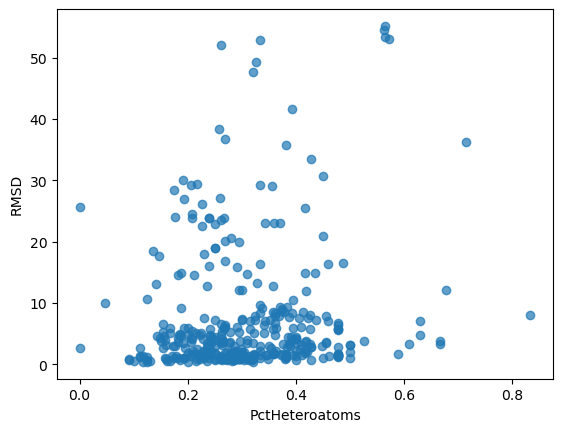

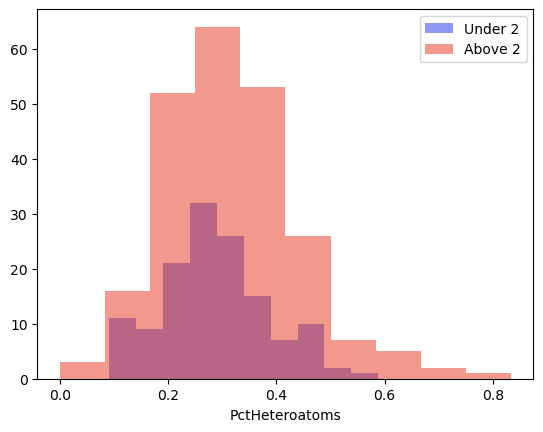

PearsonRResult(statistic=0.13252095252968857, pvalue=0.011493967193615945)
SignificanceResult(statistic=0.13492685416680636, pvalue=0.01006423834555343)
TtestResult(statistic=-2.2501559878983497, pvalue=0.025040655093081385, df=361.0)


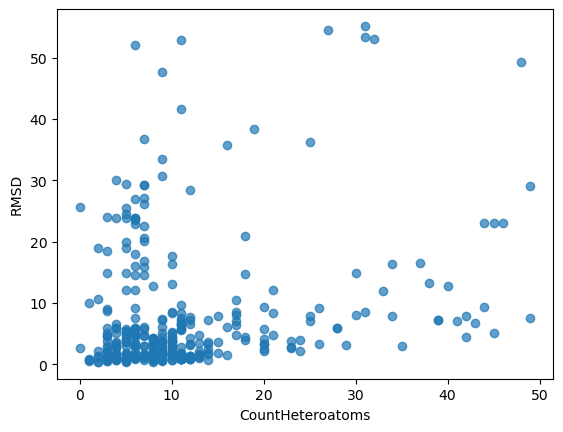

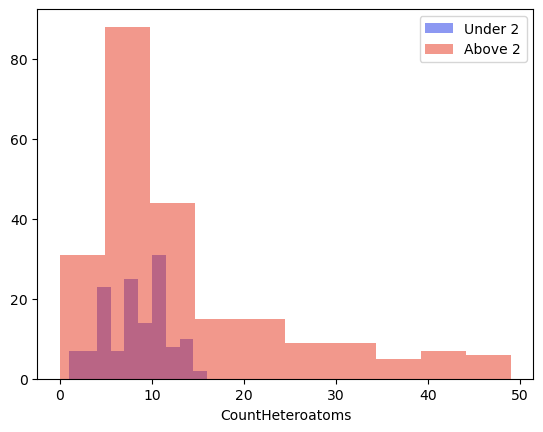

PearsonRResult(statistic=0.2504152809812254, pvalue=1.3530676680453815e-06)
SignificanceResult(statistic=0.18340791027930564, pvalue=0.0004444536763818364)
TtestResult(statistic=-5.187966085447186, pvalue=3.5527912678160007e-07, df=361.0)


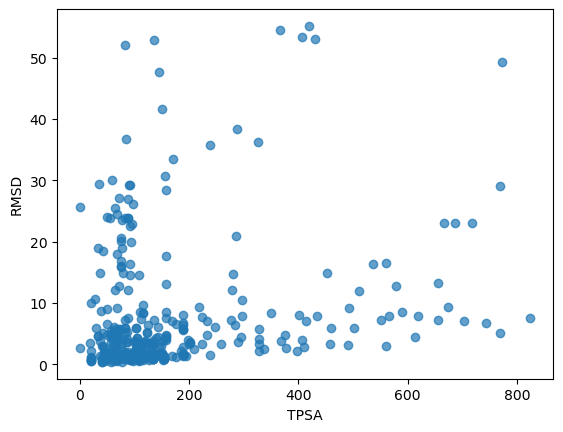

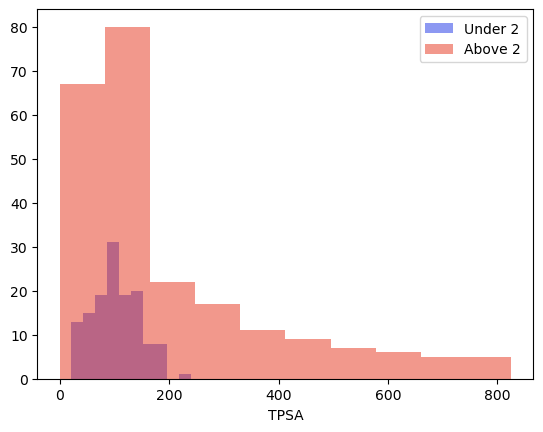

PearsonRResult(statistic=0.23760604692815257, pvalue=4.714573626536208e-06)
SignificanceResult(statistic=0.22418939795630302, pvalue=1.6203665752192236e-05)
TtestResult(statistic=-5.987110283727486, pvalue=5.158747439196019e-09, df=361.0)


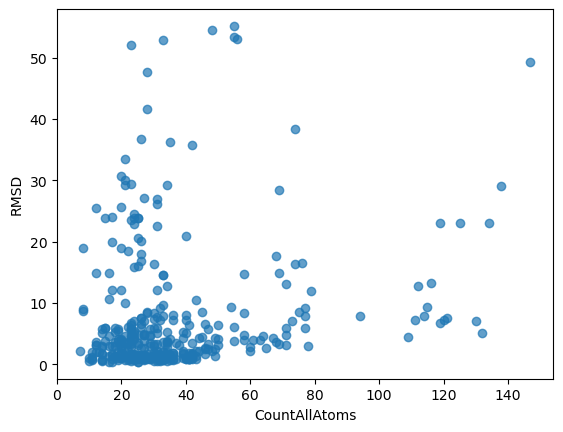

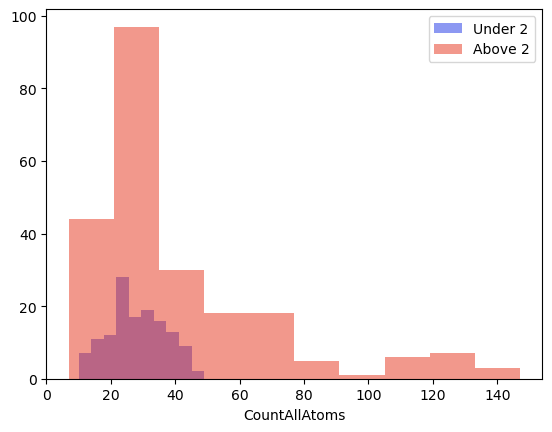

PearsonRResult(statistic=0.19744738579369608, pvalue=0.00015294238478744788)
SignificanceResult(statistic=0.1616687752263293, pvalue=0.002002028129997476)
TtestResult(statistic=-4.871081842066389, pvalue=1.6639119751991622e-06, df=361.0)


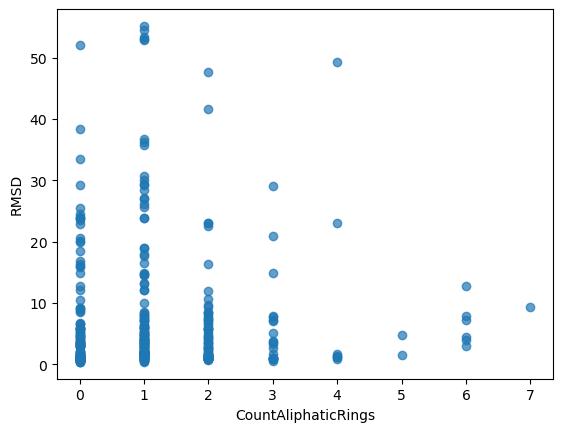

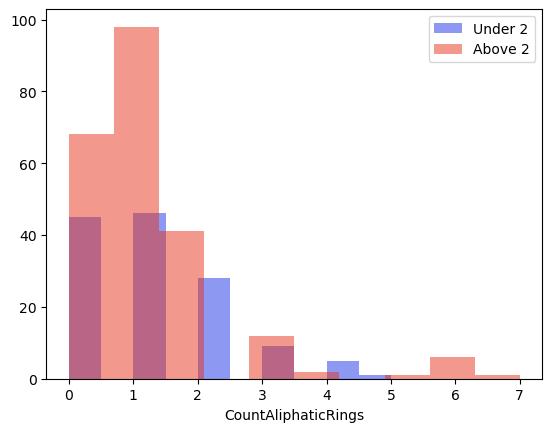

PearsonRResult(statistic=-0.017136068163472323, pvalue=0.7448906198584226)
SignificanceResult(statistic=0.01425366007973583, pvalue=0.7866634596764333)
TtestResult(statistic=-0.2906626704380987, pvalue=0.7714762328710565, df=361.0)


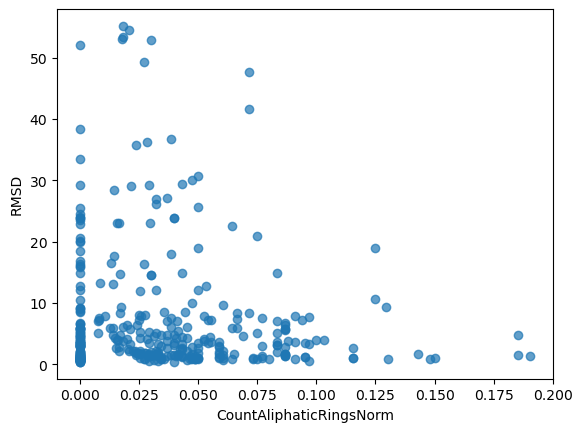

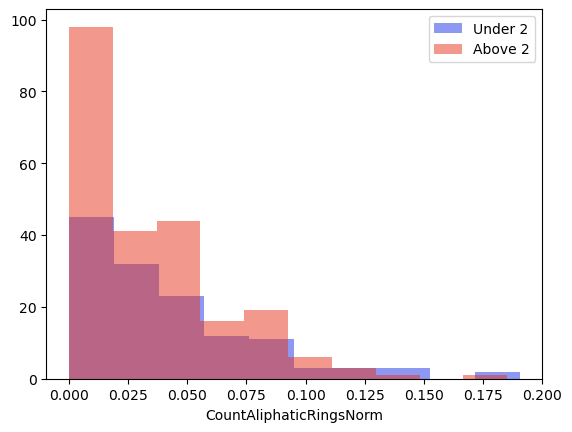

PearsonRResult(statistic=-0.10333163760327073, pvalue=0.0491589119999002)
SignificanceResult(statistic=-0.05815337003360341, pvalue=0.2691229512168707)
TtestResult(statistic=1.639496093646949, pvalue=0.10198108210289102, df=361.0)


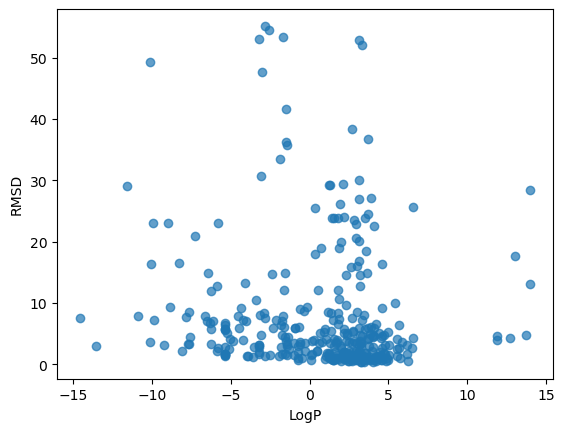

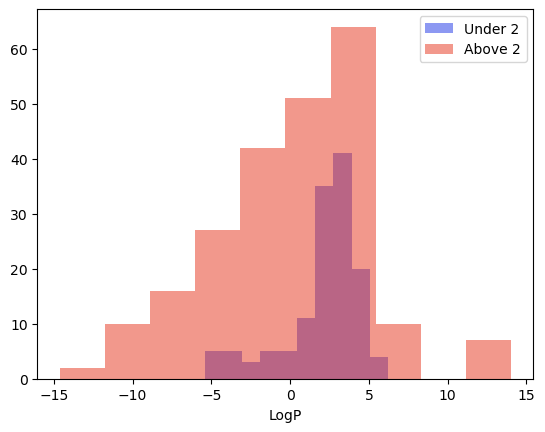

PearsonRResult(statistic=-0.1338831301277498, pvalue=0.010663883401532724)
SignificanceResult(statistic=-0.2555328536696331, pvalue=8.059771210818158e-07)
TtestResult(statistic=4.436551905512359, pvalue=1.2155301246775482e-05, df=361.0)


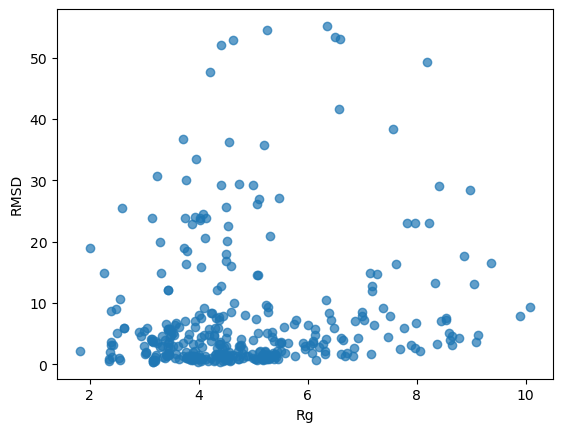

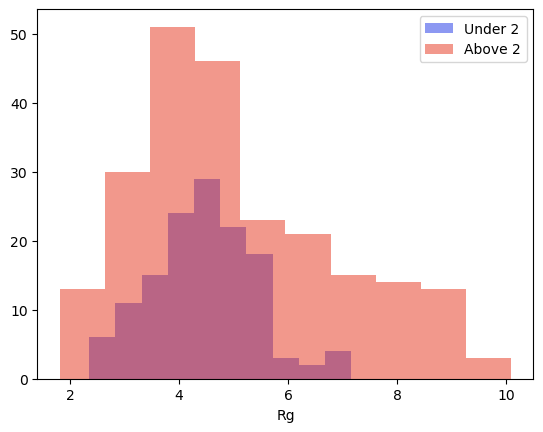

PearsonRResult(statistic=0.15126700221577613, pvalue=0.0038680890260342836)
SignificanceResult(statistic=0.14453452122964933, pvalue=0.005802207425505227)
TtestResult(statistic=-3.7330721051768703, pvalue=0.000219690173201465, df=361.0)


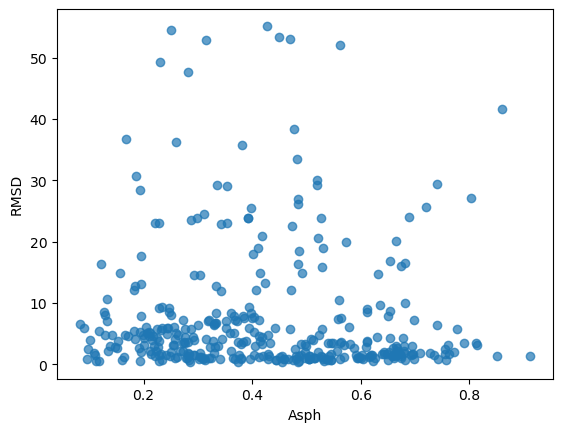

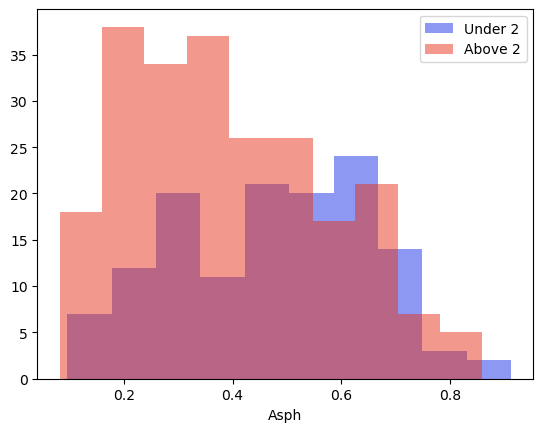

PearsonRResult(statistic=-0.044777962249843394, pvalue=0.39498100994124924)
SignificanceResult(statistic=-0.14976234212798753, pvalue=0.0042409651852841)
TtestResult(statistic=4.009241066108139, pvalue=7.403808864782215e-05, df=361.0)


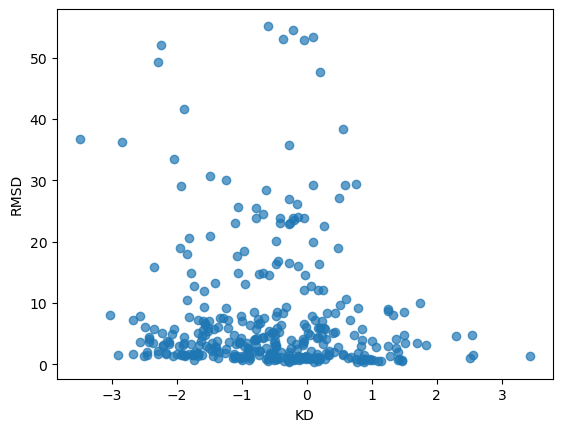

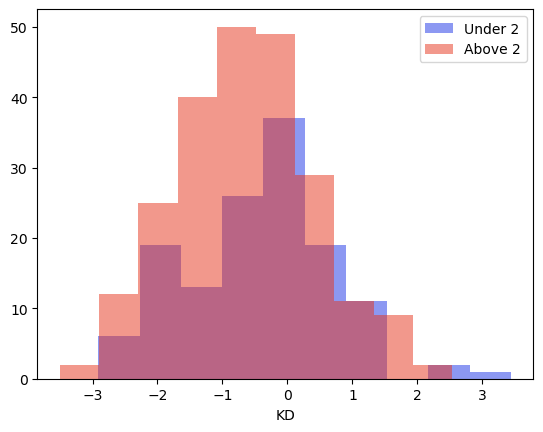

PearsonRResult(statistic=-0.08487872934439959, pvalue=0.10642029722474855)
SignificanceResult(statistic=-0.14797377277968968, pvalue=0.004726235624220402)
TtestResult(statistic=2.508572762056264, pvalue=0.012559700225537276, df=361.0)


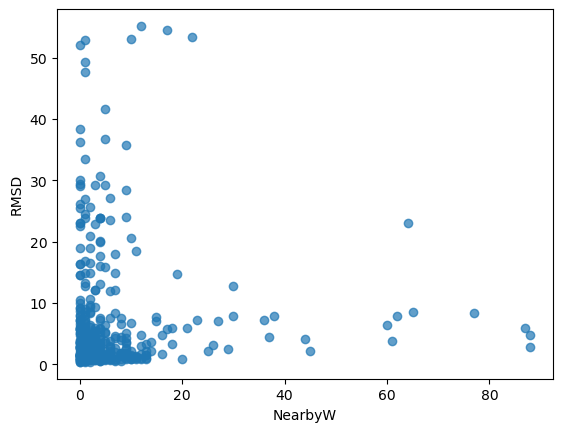

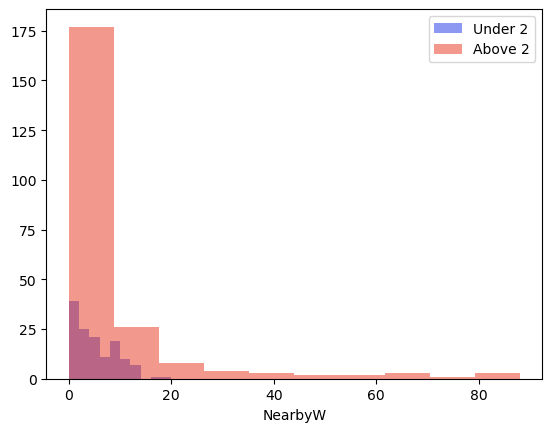

PearsonRResult(statistic=-0.006814884979816559, pvalue=0.8970453578623869)
SignificanceResult(statistic=-0.05707867709237952, pvalue=0.2780862008213676)
TtestResult(statistic=-2.4140720473106243, pvalue=0.016272252963015724, df=361.0)


In [106]:
#Scatterplot, histogram, R2 calc for each metric
pltlist = ["PctHeteroatoms", "CountHeteroatoms", "TPSA", "CountAllAtoms", "CountAliphaticRings", "CountAliphaticRingsNorm", "LogP", "Rg", "Asph", "KD", "NearbyW"]

#iterate over metrics
for p in pltlist:
    plt.scatter(df_pdb[p], df_pdb["top_rmsd"], alpha = 0.7)
    plt.xlabel(p)
    plt.ylabel("RMSD")
    plt.show()
    plt.close()
    
    #split histogram. by rmsd
    less_than_2 = df_pdb[df_pdb["top_rmsd"] < 2][p]
    greater_than_2 = df_pdb[df_pdb["top_rmsd"] >= 2][p]
    plt.hist(less_than_2, color = [0.1, 0.2, 0.9], label = "Under 2", alpha = 0.5)
    plt.hist(greater_than_2, color = [0.9, 0.2, 0.1], label = "Above 2", alpha = 0.5)
    plt.xlabel(p)
    plt.legend()
    plt.show()
    plt.close()

    print(scipy.stats.pearsonr(df_pdb[p], df_pdb["top_rmsd"]))
    #spearman thank you Jeremy for the suggestion!
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    print(scipy.stats.spearmanr(df_pdb[p], df_pdb["top_rmsd"]))
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    #TODO- is this the correct test?
    print(scipy.stats.ttest_ind(less_than_2, greater_than_2))

In [107]:
#Chi square test
binding_site_dictionary = {"under_2" : {},
                           "over_2" : {}}

list_aas = ["ALA", 
               "CYS", 
               "ASP", 
               "GLU",
               "PHE", 
               "GLY", 
               "HIS", 
               "ILE", 
               "LYS", 
               "LEU", 
               "MET", 
               "ASN", 
               "PRO", 
               "GLN", 
               "ARG", 
               "SER",
               "THR",
               "VAL",
               "TRP",
               "TYR"]
#Names from Ref https://resources.qiagenbioinformatics.com/manuals/clcgenomicsworkbench/650/Hydrophobicity_scales.html
for rmsdk in binding_site_dictionary.keys():
    for aa in list_aas:
        binding_site_dictionary[rmsdk][aa] = 0

#Iterate over data frame
for df_entry in range(0, len(df_pdb)): #range(0, len(df_pdb)):
    #print(f"entry {df_entry}")
    #print(f"rmsd {df_pdb['names'][df_entry]}")
    #print(f"rmsd {df_pdb['top_rmsd'][df_entry]}")
    #print(f"residues {df_pdb['Residues'][df_entry]}")
    
    if df_pdb["top_rmsd"][df_entry] >= 2.0:
        key_use = "over_2"
    else:
        key_use = "under_2"
    
    for aa_add in df_pdb["Residues"][df_entry]:
        if aa_add != "MSE": #maybe add back in?
            binding_site_dictionary[key_use][aa_add] += 1
    #print(binding_site_dictionary)

KstestResult(statistic=0.8, pvalue=1.3259673752008224e-06, statistic_location=112, statistic_sign=1)
AA Under 2 freq Over 2 freq Multiplier
ALA 98 281  0.35
ARG 93 247  0.38
ASN 76 235  0.32
ASP 197 396  0.50
CYS 33 100  0.33
GLN 27 221  0.12
GLU 83 319  0.26
GLY 226 400  0.56
HIS 57 203  0.28
ILE 111 231  0.48
LEU 112 390  0.29
LYS 52 229  0.23
MET 49 107  0.46
PHE 73 286  0.26
PRO 56 193  0.29
SER 79 330  0.24
THR 74 296  0.25
TRP 48 195  0.25
TYR 99 350  0.28
VAL 100 326  0.31
SignificanceResult(statistic=0.25962449003498966, pvalue=0.2689837363861518)


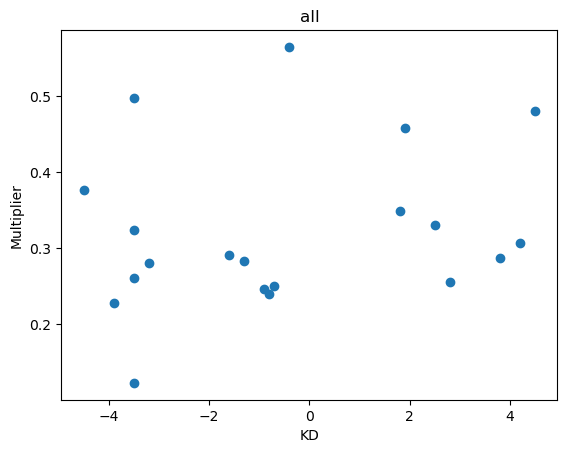

SignificanceResult(statistic=0.22026645449672183, pvalue=0.36486273693786087)


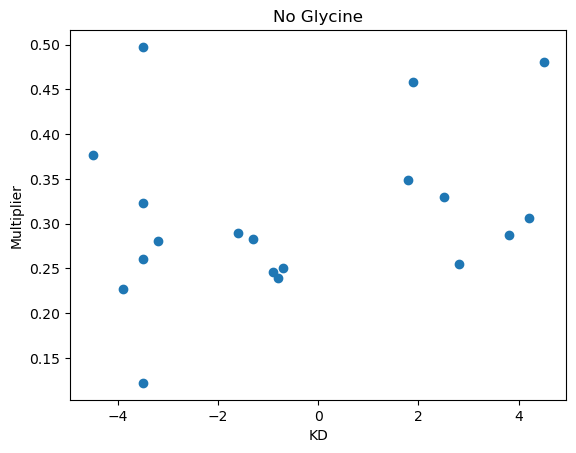

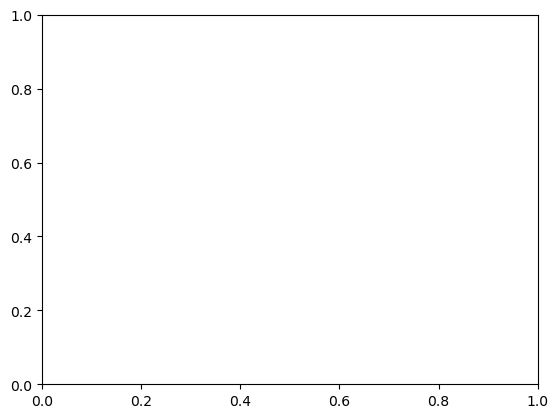

In [108]:
#Significance test of aa differences
#Ref https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets
#Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
under_2_list = [binding_site_dictionary["under_2"][a] for a in list_aas]
over_2_list = [binding_site_dictionary["over_2"][a] for a in list_aas]
summed_list = [binding_site_dictionary["under_2"][a] + binding_site_dictionary["over_2"][a] for a in list_aas]

#Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
#But different overall counts
#scipy.stats.chisquare(under_2_list, over_2_list)
#scipy.stats.chisquare(over_2_list, under_2_list)
print(stats.ks_2samp(under_2_list, over_2_list))

#Does aa chemistry affect partitioning?
print("AA Under 2 freq Over 2 freq Multiplier")
aa_dict_of_mult = {}
for aa in sorted(list_aas):
    print(f"{aa} {binding_site_dictionary['under_2'][aa]} {binding_site_dictionary['over_2'][aa]} {binding_site_dictionary['under_2'][aa] / binding_site_dictionary['over_2'][aa] : .2f}")
    aa_dict_of_mult[aa] = binding_site_dictionary['under_2'][aa] / binding_site_dictionary['over_2'][aa]
    
#Ref https://resources.qiagenbioinformatics.com/manuals/clcgenomicsworkbench/650/Hydrophobicity_scales.html
kd_dict = {"ALA" : 1.8,
"CYS" : 2.5,
"ASP" : -3.5,
"GLU" : -3.5,
"PHE" : 2.8,
"GLY" : -0.4,
"HIS" : -3.2,
"ILE" : 4.5,
"LYS" : -3.9,
"LEU" : 3.8,
"MET" : 1.9,
"ASN" : -3.5,
"PRO" : -1.6,
"GLN" : -3.5,
"ARG" : -4.5,
"SER" : -0.8,
"THR" : -0.7,
"VAL" : 4.2,
"TRP" : -0.9,
"TYR" : -1.3}

kd_list = []
mult_list = []
kd_list_no_gly = []
mult_list_no_gly = []

for aa_pl in list_aas:
    kd_list.append(kd_dict[aa_pl])
    mult_list.append(aa_dict_of_mult[aa_pl])
    if aa_pl != "GLY":
        kd_list_no_gly.append(kd_dict[aa_pl])
        mult_list_no_gly.append(aa_dict_of_mult[aa_pl])

plt.scatter(kd_list, mult_list)

#spearman thank you Jeremy for the suggestion!
#ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
plt.title("all")
print(scipy.stats.spearmanr(kd_list, mult_list))
plt.xlabel("KD")
plt.ylabel("Multiplier")
plt.show()
plt.close()
plt.clf()
plt.cla()

plt.scatter(kd_list_no_gly, mult_list_no_gly)

#spearman thank you Jeremy for the suggestion!
#ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
print(scipy.stats.spearmanr(kd_list_no_gly, mult_list_no_gly))
plt.title("No Glycine")
plt.xlabel("KD")
plt.ylabel("Multiplier")
plt.show()
plt.close()
plt.clf()
plt.cla()

In [26]:
for d in range(0, len(df_pdb)): print(f'name {df_pdb["names"][d]} rmsd {df_pdb["top_rmsd"][d]} conf {df_pdb["top_confidence"][d]}')

name 6qqw rmsd 0.9898587811095729 conf 0.275576114654541
name 6d08 rmsd 3.306565374152745 conf -2.1367692947387695
name 6jap rmsd 2.7590960538054117 conf -1.0503170490264893
name 6np2 rmsd 3.348641186414294 conf -1.3641011714935303
name 6uvp rmsd 0.8940085852296085 conf 0.940610945224762
name 6oxq rmsd 0.9020278517762146 conf 0.49125978350639343
name 6jsn rmsd 1.1547994564029826 conf 0.7386958003044128
name 6hzb rmsd 4.7740320294565555 conf -1.8337191343307495
name 6qrc rmsd 4.039643233744244 conf -0.047578223049640656
name 6oio rmsd 16.050483436077002 conf -0.8117192983627319
name 6jag rmsd 5.521851884152145 conf -1.0346876382827759
name 6moa rmsd 0.46929031791663567 conf 0.6868524551391602
name 6hld rmsd 9.207651108934957 conf -2.3005614280700684
name 6i9a rmsd 6.475661774582021 conf -2.2627904415130615
name 6e4c rmsd 1.6634683764274623 conf 0.03821568936109543
name 6g24 rmsd 14.922841457264667 conf -0.3718869090080261
name 6jb4 rmsd 1.6892476325805206 conf -0.7410680651664734
name 6